# Project in Machine Learning Class: Predict user's review sentiment

### John Koumentis, MTN2012

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
!python -m spacy download el_core_news_sm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import metrics
from sklearn.utils import resample

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')


## Load and pre-process data

The data used comes from the 'Amazon Cell Phones Reviews' dataset found in Kaggle (https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews)

In [2]:
#Read the reviews dataset
df = pd.read_csv('20191226-reviews.csv')
df = df.drop('name', axis=1)

In [3]:
#Check for missing data
missing_data = df.isnull().sum()
print(missing_data)

asin                0
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64


In [4]:
#Remove empty reviews
empty_reviews = np.where(pd.isnull(df.body))
df.drop(list(empty_reviews)[0],inplace=True)
empty_reviews

(array([ 9445, 18055, 19749, 20892, 21149, 21887, 22917, 29501, 30010,
        35596, 36845, 43415, 45899, 46470, 51628, 52176, 55171, 57837,
        61074, 62205, 64371], dtype=int64),)

In [5]:
df.head(10)

,asin,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,4,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
6,B0000SX2UC,5,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0
7,B0000SX2UC,4,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0
8,B0000SX2UC,5,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0
9,B0000SX2UC,3,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0


In [6]:
#Isolate body and rating columns in a new dataset
reviews_dataset = pd.DataFrame({'reviews':df.body.values, 'ratings':df.rating.values})
#reviews_dataset.to_csv('reviews.csv')
reviews_dataset.head()

,reviews,ratings
0,I had the Samsung A600 for awhile which is abs...,3
1,Due to a software issue between Nokia and Spri...,1
2,"This is a great, reliable phone. I also purcha...",5
3,"I love the phone and all, because I really did...",3
4,The phone has been great for every purpose it ...,4


After removing the lines containing the empty reviews and creating a new dataset by keeping only the reviews and ratings column, the reviews column was loaded in XLSX format at https://translate.google.gr/?hl=el&sl=auto&tl=el&op=docs and translated. The output was an HTML table that was launched via Excel and stored in CSV format with name 'translate.csv'.

In [7]:
translated = pd.read_csv('translate.csv',header=None)
reviews_dataset.insert(loc=1, column='greek', value=translated)
reviews_dataset.head(10)

,reviews,greek,ratings
0,I had the Samsung A600 for awhile which is abs...,Είχα το Samsung A600 για λίγο που είναι απόλυτ...,3
1,Due to a software issue between Nokia and Spri...,Λόγω ενός προβλήματος λογισμικού μεταξύ της No...,1
2,"This is a great, reliable phone. I also purcha...","Αυτό είναι ένα υπέροχο, αξιόπιστο τηλέφωνο. Αγ...",5
3,"I love the phone and all, because I really did...","Λατρεύω το τηλέφωνο και όλα, γιατί πραγματικά ...",3
4,The phone has been great for every purpose it ...,Το τηλέφωνο ήταν τέλειο για κάθε σκοπό που προ...,4
5,"Hello, I have this phone and used it until I d...","Γεια σας, έχω αυτό το τηλέφωνο και το χρησιμοπ...",4
6,Cool. Cheap. Color: 3 words that describe the ...,Δροσερός. Φτηνός. Χρώμα: 3 λέξεις που περιγράφ...,5
7,"The 3599i is overall a nice phone, except that...","Το 3599i είναι γενικά ένα ωραίο τηλέφωνο, εκτό...",4
8,"I've never owned a Nokia phone before, so this...","Δεν είχα ποτέ προηγουμένως τηλέφωνο Nokia, γι ...",5
9,ok well im in school and i need the text messa...,"εντάξει, είμαι στο σχολείο και χρειάζομαι τα γ...",3


Introducing a function to clean the translated text, that converts words to lowercase, removes punctuation and stopwords and applies lemmatization.

In [8]:
#Clean reviews text
punctuation = set(string.punctuation)
latin = re.compile(r'[^a-zÀ-ÿ]+')
nlp = spacy.load('el_core_news_sm')

def clean_text(text):
    # Convert the text into lowercase
    text = text.lower()
    # Remove Latin characters
    wordList = latin.findall(text)
    # Remove punctuation
    wordList = ["".join(x for x in word if (x=="'")|(x not in punctuation)) for word in wordList]
    # Remove stopwords
    wordList = [word for word in wordList if word not in stopwords.words('greek')]
    # Lemmatisation
    cleaned_text = nlp(" ".join(wordList))
    cleaned_text = [token.lemma_ for token in cleaned_text]
    return " ".join(cleaned_text)

Due to long execution time the results of the following cell execution were stored in the cleaned.csv file, to get retrieved directly from there.

In [9]:
#import time
#start = time.process_time()
#reviews_dataset['cleaned_text'] = reviews_dataset['greek'].apply(clean_text)
#print(time.process_time() - start)
#reviews_dataset.to_csv('cleaned.csv')
reviews_dataset = pd.read_csv('cleaned.csv',index_col=0)

C:\Users\John\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ratings', ylabel='count'>

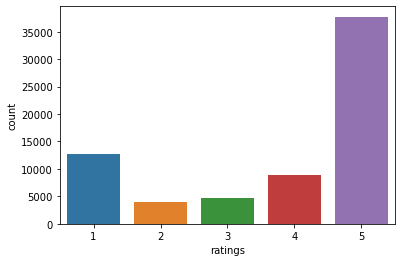

In [10]:
# Check the ratings count

sns.countplot(reviews_dataset['ratings'])

The `4` and `5` star (positive) ratings combined are more than the `1`,`2` ones (negative) combined. Hence, I decided to add the `3` star ratings to the negative ratings. In order to simplify the situation, I replaced the `4`,`5` star ratings with the label `1`, to indicate positive sentiment and the `1`,`2`,`3` star ratings with the label `0`, to indicate negative sentiment.

In [11]:
sentiment_dict = {1:0, 2:0, 3:0, 4:1, 5:1}
reviews_dataset['ratings'].replace(sentiment_dict,inplace=True)
reviews_dataset.head(10)

,reviews,greek,ratings,cleaned_text
0,I had the Samsung A600 for awhile which is abs...,Είχα το Samsung A600 για λίγο που είναι απόλυτ...,0,έχω το 600 για λίγο που είναι απόλυτος ...
1,Due to a software issue between Nokia and Spri...,Λόγω ενός προβλήματος λογισμικού μεταξύ της No...,0,λόγω ενός προβλήματος λογισμικός μεταξύ της ...
2,"This is a great, reliable phone. I also purcha...","Αυτό είναι ένα υπέροχο, αξιόπιστο τηλέφωνο. Αγ...",1,αυτό είναι ένα υπέροχος αξιόπιστος τηλέφωνο αγ...
3,"I love the phone and all, because I really did...","Λατρεύω το τηλέφωνο και όλα, γιατί πραγματικά ...",0,λατρεύω το τηλέφωνος και όλος γιατί πραγματικά...
4,The phone has been great for every purpose it ...,Το τηλέφωνο ήταν τέλειο για κάθε σκοπό που προ...,1,το τηλέφωνος ήταν τέλειος για κάθε σκοπό που π...
5,"Hello, I have this phone and used it until I d...","Γεια σας, έχω αυτό το τηλέφωνο και το χρησιμοπ...",1,γειο σας έχω αυτό το τηλέφωνος και το χρησιμοπ...
6,Cool. Cheap. Color: 3 words that describe the ...,Δροσερός. Φτηνός. Χρώμα: 3 λέξεις που περιγράφ...,1,δροσερός φτηνό χρώμα 3 λέξει που περιγράφω τέλ...
7,"The 3599i is overall a nice phone, except that...","Το 3599i είναι γενικά ένα ωραίο τηλέφωνο, εκτό...",1,το 3599 είναι γενικά ένα ωραίος τηλέφωνο εκτ...
8,"I've never owned a Nokia phone before, so this...","Δεν είχα ποτέ προηγουμένως τηλέφωνο Nokia, γι ...",1,δεν έχω ποτέ προηγουμένως τηλέφωνος γι ' αυ...
9,ok well im in school and i need the text messa...,"εντάξει, είμαι στο σχολείο και χρειάζομαι τα γ...",0,εντάξω είμαι στο σχολείο και χρειάζομαι τα γρα...


C:\Users\John\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ratings', ylabel='count'>

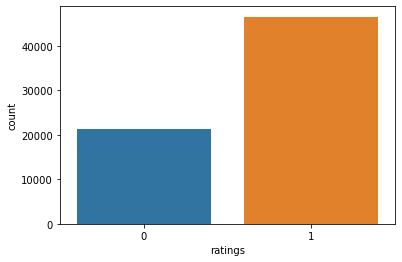

In [12]:
sns.countplot(reviews_dataset['ratings'])

After cleaning the data, there were some reviews that provided empty result:

In [13]:
missing_data = reviews_dataset.isnull().sum()
print(missing_data)

reviews           0
greek             0
ratings           0
cleaned_text    224
dtype: int64


In [14]:
nans = np.where(pd.isnull(reviews_dataset.cleaned_text))
reviews_dataset.drop(list(nans)[0],inplace=True)
empty_reviews

(array([ 9445, 18055, 19749, 20892, 21149, 21887, 22917, 29501, 30010,
        35596, 36845, 43415, 45899, 46470, 51628, 52176, 55171, 57837,
        61074, 62205, 64371], dtype=int64),)

In [15]:
#Isolate cleaned text and ratings columns in a new dataset
reviews = pd.DataFrame({'reviews':reviews_dataset.cleaned_text.values, 'ratings':reviews_dataset.ratings.values})
#reviews_dataset.to_csv('reviews.csv')
reviews.head()

,reviews,ratings
0,έχω το 600 για λίγο που είναι απόλυτος ...,0
1,λόγω ενός προβλήματος λογισμικός μεταξύ της ...,0
2,αυτό είναι ένα υπέροχος αξιόπιστος τηλέφωνο αγ...,1
3,λατρεύω το τηλέφωνος και όλος γιατί πραγματικά...,0
4,το τηλέφωνος ήταν τέλειος για κάθε σκοπό που π...,1


In [16]:
greek_reviews = reviews.reviews
labels = reviews.ratings

## Check Positive and Negative usage of words

In [17]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [18]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for i in range(len(reviews)):
    try:
        for word in greek_reviews[i].split(" "):
            total_counts[word] += 1
            if labels[i] == 1:
                positive_counts[word] += 1
            else:
                negative_counts[word] += 1
    except KeyError:
        pass

In [19]:
pos_neg_ratios = Counter()
pos_neg_ratios_log = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratios[term] = positive_counts[term] / float(negative_counts[term]+1)
        
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios_log[word] = np.log(ratio)

In [20]:
print("Pos-to-neg ratio for 'λόγω' = {}".format(pos_neg_ratios_log["λόγω"]))
print("Pos-to-neg ratio for 'υπέροχο' = {}".format(pos_neg_ratios_log["υπέροχο"]))
print("Pos-to-neg ratio for 'απογοητευμένος' = {}".format(pos_neg_ratios_log["απογοητευμένος"]))

Pos-to-neg ratio for 'λόγω' = 0.2786746254947829
Pos-to-neg ratio for 'υπέροχο' = 2.230780268863374
Pos-to-neg ratio for 'απογοητευμένος' = -1.6123747721074102


Neutral words like 'λόγω' have logarithmic pos-to-neg ratio slightly larger than zero. Positive words like 'υπέροχο' logarithmic ratio is larger than `1`, that means it is used mostly in positive reviews, whereas negative words like 'απογοητευμένος' have a ratio value smaller than `-1` indicating that they are used mostly in negative reviews.

In [21]:
dict(pos_neg_ratios_log.most_common()[-10:])

{'χρημάτο': -1.9745325952326636,
 'ελαττωματικό': -1.9830278120118159,
 'τυχαίας': -2.01138807843482,
 'απενεργοποιείται': -2.0149030205422647,
 'κολλημένος': -2.087223682121891,
 'επιστροφός': -2.129313371720009,
 'επισκευή': -2.132581721074134,
 'απάτη': -2.167548809190103,
 'σπατάλη': -2.468099531471619,
 'αγορασω': -2.6026896854443837}

In [22]:
dict(pos_neg_ratios_log.most_common()[0:10])

{'εξοχο': 4.6913478822291435,
 'δουλευει': 4.518158808998462,
 'τελεια': 3.817712325956905,
 '👍': 3.7796338173824005,
 'νικήσω': 3.2358734012367716,
 'αγαπω': 3.0647251450409425,
 'ανησυχούσας': 3.005682604407159,
 'λατρεύω': 2.807116439488649,
 'οπως': 2.7990219793079367,
 'προσιτός': 2.70805020110221}

As a final preparation step, the tf-idf vectorizer was used to transform the words in vectors according to their frequency and importance. As it is mentioned at the corresponding scikit learn documentation topic, the goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [23]:
tfidf = TfidfVectorizer()
vectorized = tfidf.fit_transform([reviews.reviews[0]])
print(vectorized[0,0:20])

  (0, 12)	0.025375480354459794
  (0, 10)	0.025375480354459794
  (0, 7)	0.025375480354459794
  (0, 19)	0.025375480354459794
  (0, 16)	0.025375480354459794
  (0, 4)	0.025375480354459794
  (0, 1)	0.025375480354459794
  (0, 15)	0.025375480354459794
  (0, 2)	0.025375480354459794
  (0, 11)	0.025375480354459794
  (0, 3)	0.025375480354459794
  (0, 13)	0.025375480354459794
  (0, 17)	0.025375480354459794
  (0, 9)	0.025375480354459794
  (0, 18)	0.025375480354459794
  (0, 5)	0.025375480354459794
  (0, 14)	0.025375480354459794
  (0, 8)	0.025375480354459794
  (0, 0)	0.025375480354459794
  (0, 6)	0.07612644106337939


## Machine Learning Pipeline

In [24]:
X = reviews['reviews']
y = reviews['ratings']

In [25]:
def model_training(X,y,algorithm):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

    model_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', algorithm),
    ])
    
    #print algorithm
    print('Using',str(algorithm),'algorithm\n')
    
    # Feed the training data through the pipeline
    model_clf.fit(X_train, y_train) 

    # Form a prediction set
    predictions = model_clf.predict(X_test)

    # Report the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_test,predictions)
    print('Confusion Matrix\n{}\n'.format(confusion_matrix))

    # Create a classification report
    report = metrics.classification_report(y_test,predictions)
    print('Classification report\n{}\n'.format(report))

    # Calculate the overall accuracy
    accuracy_score = metrics.accuracy_score(y_test,predictions)
    precision = metrics.precision_score(y_test,predictions)
    recall = metrics.recall_score(y_test,predictions)
    f1_score = metrics.f1_score(y_test,predictions)
    print('Overall accuracy: {}\nPrecision: {}\nRecall: {}\nF1-Score: {}\n\n'.format(accuracy_score,precision,
                                                                                 recall,f1_score))
    #Plot ROC curve
    metrics.plot_roc_curve(model_clf,X_test,y_test)
    plt.title(str(algorithm)+' ROC curve')
    plt.show()
    return model_clf

Using MultinomialNB() algorithm

Confusion Matrix
[[ 3434  2989]
 [  295 13605]]

Classification report
              precision    recall  f1-score   support

           0       0.92      0.53      0.68      6423
           1       0.82      0.98      0.89     13900

    accuracy                           0.84     20323
   macro avg       0.87      0.76      0.78     20323
weighted avg       0.85      0.84      0.82     20323


Overall accuracy: 0.8384096836097032
Precision: 0.819874653489213
Recall: 0.9787769784172662
F1-Score: 0.8923066832819572




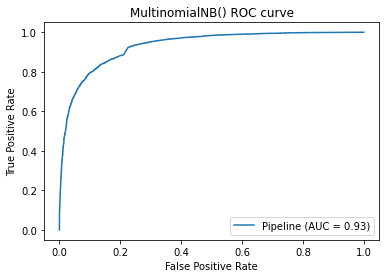

Using LinearSVC() algorithm

Confusion Matrix
[[ 5074  1349]
 [  895 13005]]

Classification report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      6423
           1       0.91      0.94      0.92     13900

    accuracy                           0.89     20323
   macro avg       0.88      0.86      0.87     20323
weighted avg       0.89      0.89      0.89     20323


Overall accuracy: 0.8895832308222211
Precision: 0.9060192280897311
Recall: 0.935611510791367
F1-Score: 0.92057761732852




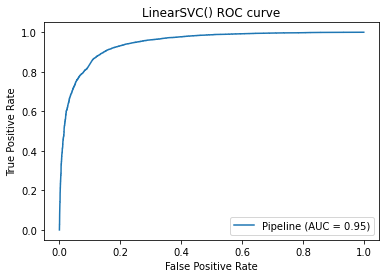

Using RandomForestClassifier() algorithm

Confusion Matrix
[[ 4372  2051]
 [  579 13321]]

Classification report
              precision    recall  f1-score   support

           0       0.88      0.68      0.77      6423
           1       0.87      0.96      0.91     13900

    accuracy                           0.87     20323
   macro avg       0.87      0.82      0.84     20323
weighted avg       0.87      0.87      0.87     20323


Overall accuracy: 0.8705899719529597
Precision: 0.8665755919854281
Recall: 0.9583453237410072
F1-Score: 0.9101530472806779




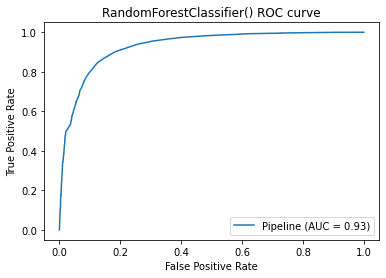

Using GradientBoostingClassifier() algorithm

Confusion Matrix
[[ 3921  2502]
 [  990 12910]]

Classification report
              precision    recall  f1-score   support

           0       0.80      0.61      0.69      6423
           1       0.84      0.93      0.88     13900

    accuracy                           0.83     20323
   macro avg       0.82      0.77      0.79     20323
weighted avg       0.83      0.83      0.82     20323


Overall accuracy: 0.8281749741671998
Precision: 0.8376589670386712
Recall: 0.9287769784172661
F1-Score: 0.880867903930131




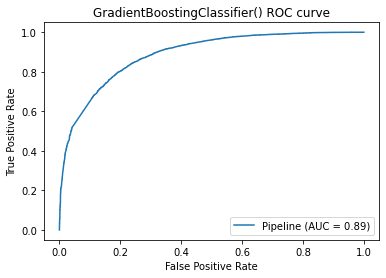

In [26]:
text_nb = model_training(X,y,MultinomialNB())
text_svm = model_training(X,y,LinearSVC())
text_rf = model_training(X,y,RandomForestClassifier())
text_gb = model_training(X,y,GradientBoostingClassifier())

### Balance positive and negative reviews and re-train

In [27]:
reviews['ratings'].value_counts()

1    46352
0    21389
Name: ratings, dtype: int64

In [28]:
majority = reviews[reviews.ratings == 1]
minority = reviews[reviews.ratings == 0]

downsampled_majority = resample(majority,replace=False, n_samples=len(minority), random_state=4)

reviews_downsampled = pd.concat([downsampled_majority, minority])
 
reviews_downsampled['ratings'].value_counts()

1    21389
0    21389
Name: ratings, dtype: int64

In [29]:
X_downsampled = reviews_downsampled['reviews']
y_downsampled = reviews_downsampled['ratings']

Using MultinomialNB() algorithm

Confusion Matrix
[[5654  682]
 [1233 5265]]

Classification report
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      6336
           1       0.89      0.81      0.85      6498

    accuracy                           0.85     12834
   macro avg       0.85      0.85      0.85     12834
weighted avg       0.85      0.85      0.85     12834


Overall accuracy: 0.8507869721053452
Precision: 0.8853203295779385
Recall: 0.8102493074792244
F1-Score: 0.8461229409401366




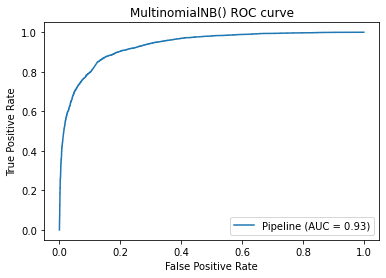

Using LinearSVC() algorithm

Confusion Matrix
[[5450  886]
 [ 752 5746]]

Classification report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      6336
           1       0.87      0.88      0.88      6498

    accuracy                           0.87     12834
   macro avg       0.87      0.87      0.87     12834
weighted avg       0.87      0.87      0.87     12834


Overall accuracy: 0.8723702664796634
Precision: 0.8664053075995175
Recall: 0.8842720837180671
F1-Score: 0.8752475247524752




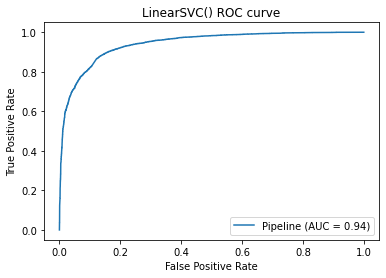

Using RandomForestClassifier() algorithm

Confusion Matrix
[[5625  711]
 [1217 5281]]

Classification report
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      6336
           1       0.88      0.81      0.85      6498

    accuracy                           0.85     12834
   macro avg       0.85      0.85      0.85     12834
weighted avg       0.85      0.85      0.85     12834


Overall accuracy: 0.8497740377123266
Precision: 0.8813417890520694
Recall: 0.8127116035703293
F1-Score: 0.8456365092073659




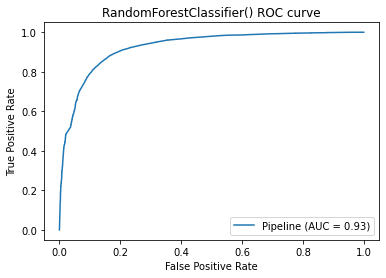

Using GradientBoostingClassifier() algorithm

Confusion Matrix
[[4974 1362]
 [1188 5310]]

Classification report
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6336
           1       0.80      0.82      0.81      6498

    accuracy                           0.80     12834
   macro avg       0.80      0.80      0.80     12834
weighted avg       0.80      0.80      0.80     12834


Overall accuracy: 0.8013090229079008
Precision: 0.795863309352518
Recall: 0.817174515235457
F1-Score: 0.806378132118451




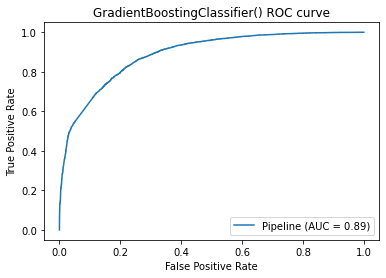

In [30]:
text_nb_downsampled = model_training(X_downsampled,y_downsampled,MultinomialNB())
text_svm_downsampled = model_training(X_downsampled,y_downsampled,LinearSVC())
text_rf_downsampled = model_training(X_downsampled,y_downsampled,RandomForestClassifier())
text_gb_downsampled = model_training(X_downsampled,y_downsampled,GradientBoostingClassifier())

In [31]:
upsampled_minority = resample(minority,replace=True, n_samples=len(majority), random_state=4)

reviews_upsampled = pd.concat([upsampled_minority, majority])
 
reviews_upsampled['ratings'].value_counts()

1    46352
0    46352
Name: ratings, dtype: int64

In [32]:
X_upsampled = reviews_upsampled['reviews']
y_upsampled = reviews_upsampled['ratings']

Using MultinomialNB() algorithm

Confusion Matrix
[[12414  1389]
 [ 2505 11504]]

Classification report
              precision    recall  f1-score   support

           0       0.83      0.90      0.86     13803
           1       0.89      0.82      0.86     14009

    accuracy                           0.86     27812
   macro avg       0.86      0.86      0.86     27812
weighted avg       0.86      0.86      0.86     27812


Overall accuracy: 0.8599884941751762
Precision: 0.8922671216939424
Recall: 0.8211863801841673
F1-Score: 0.8552523975912572




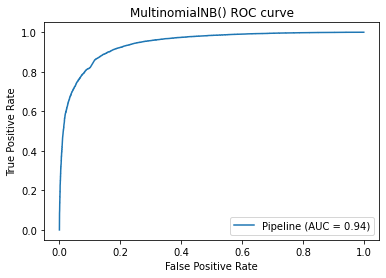

Using LinearSVC() algorithm

Confusion Matrix
[[12618  1185]
 [ 1393 12616]]

Classification report
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     13803
           1       0.91      0.90      0.91     14009

    accuracy                           0.91     27812
   macro avg       0.91      0.91      0.91     27812
weighted avg       0.91      0.91      0.91     27812


Overall accuracy: 0.9073061987631238
Precision: 0.9141366567640026
Recall: 0.9005639231922336
F1-Score: 0.9072995325422509




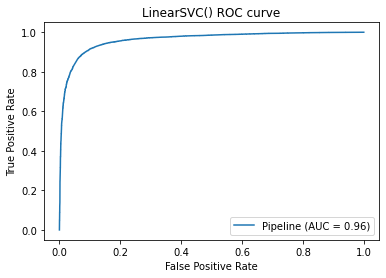

Using RandomForestClassifier() algorithm

Confusion Matrix
[[13049   754]
 [ 1322 12687]]

Classification report
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     13803
           1       0.94      0.91      0.92     14009

    accuracy                           0.93     27812
   macro avg       0.93      0.93      0.93     27812
weighted avg       0.93      0.93      0.93     27812


Overall accuracy: 0.9253559614554868
Precision: 0.9439029834089725
Recall: 0.9056320936540795
F1-Score: 0.9243715846994536




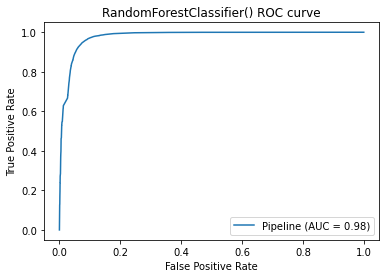

Using GradientBoostingClassifier() algorithm

Confusion Matrix
[[10931  2872]
 [ 2514 11495]]

Classification report
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     13803
           1       0.80      0.82      0.81     14009

    accuracy                           0.81     27812
   macro avg       0.81      0.81      0.81     27812
weighted avg       0.81      0.81      0.81     27812


Overall accuracy: 0.8063425859341291
Precision: 0.8000974455349064
Recall: 0.8205439360411164
F1-Score: 0.8101917113053285




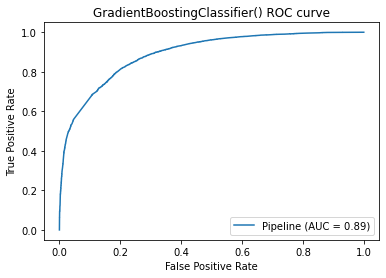

In [33]:
text_nb_upsampled = model_training(X_upsampled,y_upsampled,MultinomialNB())
text_svm_upsampled = model_training(X_upsampled,y_upsampled,LinearSVC())
text_rf_upsampled = model_training(X_upsampled,y_upsampled,RandomForestClassifier())
text_gb_upsampled = model_training(X_upsampled,y_upsampled,GradientBoostingClassifier())

#### Check prediction in reviews from https://www.skroutz.gr/s/20060269/Apple-iPhone-11-64GB-Black.html

In [34]:
review1 = 'Κατοχος περιπου 7 χρονια iphone, πιστευω πως ειναι το καλυτερο iphone που εχω παρει ποτε,\
 σε μεγεθος ειναι ο,τι πρεπει, και η μπαταρια του πολυ καλη, ειχα πετυχει μεχρι και δυο 24ωρα\
 διαρκεια μπαταριας στις αρχες που το ειχα παρει, θα μεινω αρκετο καιρο μ αυτο το κινητο απ οτι βλεπω...'

review2 = 'Εκτος απο τον γρηγορο επεξεργαστη στα υπολοιπα υστερει: Μικρη μπαταρια , δεν εχει fast charging ,\
 μολις 12 mp camera , τεραστιο notch , το face id ειναι εκνευριστικο κτλ\
 Γενικα αποφυγετε τα κινητα της Apple , το κοστος τους ειναι απολυτως δυσαναλογο με τις δυνατοτητες που προσφερουν\
 και τα χαρακτηριστηκα τους σε συγκριση με αλλα τηλεφωνα στο ιδιο ευρος χρηματων ή ακομη και σε σχεση με αρκετα\
 φθηνοτερα κινητα.'

review3 = 'Τρομερό το κινητό σε εντυπωσιάζει καθημερινά.\
Με εξαίρεση την οθόνη η οποία είναι τεχνολογικά πίσω σε σχέση με αλλά κινητά αντίστοιχης τιμής (πολύ καλή ωστόσο) \
σε όλα τα άλλα είναι φοβερό. Αστεία γρήγορο, πολύ καλή μπαταρία που βγάζει άνετα τη μέρα, απολαυστικό σε όλα και το \
iOS έχει προοδεύσει αρκετά μιας και έρχομαι από iPhone 5s και iOS 10.\
Όσοι το επιλέξετε δε θα το μετανιώσετε καθόλου.'

reviews_production = np.array([review1,review2,review3])

In [35]:
for r in reviews_production:
    print(r,'\n')
    print('Naive Bayes prediction: {}\nSVM prediction: {},\nRandom Forest prediction: {},\
    \nGradient Boosting prediction: {}'.format(text_nb.predict([clean_text(r)]),
                                         text_svm.predict([clean_text(r)]),
                                        text_rf.predict([clean_text(r)]),
                                         text_gb.predict([clean_text(r)])))
    
    print('Naive Bayes Class probabilities: {}'.format(text_nb.predict_proba([clean_text(r)])))
    print('SVM Confidence level : {}\n\n'.format(text_svm.decision_function([clean_text(r)])[0]))

Κατοχος περιπου 7 χρονια iphone, πιστευω πως ειναι το καλυτερο iphone που εχω παρει ποτε, σε μεγεθος ειναι ο,τι πρεπει, και η μπαταρια του πολυ καλη, ειχα πετυχει μεχρι και δυο 24ωρα διαρκεια μπαταριας στις αρχες που το ειχα παρει, θα μεινω αρκετο καιρο μ αυτο το κινητο απ οτι βλεπω... 

Naive Bayes prediction: [0]
SVM prediction: [1],
Random Forest prediction: [1],    
Gradient Boosting prediction: [1]
Naive Bayes Class probabilities: [[0.63172234 0.36827766]]
SVM Confidence level : 0.3545204644905444


Εκτος απο τον γρηγορο επεξεργαστη στα υπολοιπα υστερει: Μικρη μπαταρια , δεν εχει fast charging , μολις 12 mp camera , τεραστιο notch , το face id ειναι εκνευριστικο κτλ Γενικα αποφυγετε τα κινητα της Apple , το κοστος τους ειναι απολυτως δυσαναλογο με τις δυνατοτητες που προσφερουν και τα χαρακτηριστηκα τους σε συγκριση με αλλα τηλεφωνα στο ιδιο ευρος χρηματων ή ακομη και σε σχεση με αρκετα φθηνοτερα κινητα. 

Naive Bayes prediction: [0]
SVM prediction: [0],
Random Forest prediction: 

In [36]:
for r in reviews_production:
    print(r,'\n')
    print('Naive Bayes prediction: {}\nSVM prediction: {},\nRandom Forest prediction: {},\
    \nGradient Boosting prediction: {}'.format(text_nb_downsampled.predict([clean_text(r)]),
                                         text_svm_downsampled.predict([clean_text(r)]),
                                        text_rf_downsampled.predict([clean_text(r)]),
                                         text_gb_downsampled.predict([clean_text(r)])))
    
    print('Naive Bayes Class probabilities: {}'.format(text_nb_downsampled.predict_proba([clean_text(r)])))
    print('SVM Confidence level : {}\n\n'.format(text_svm_downsampled.decision_function([clean_text(r)])[0]))

Κατοχος περιπου 7 χρονια iphone, πιστευω πως ειναι το καλυτερο iphone που εχω παρει ποτε, σε μεγεθος ειναι ο,τι πρεπει, και η μπαταρια του πολυ καλη, ειχα πετυχει μεχρι και δυο 24ωρα διαρκεια μπαταριας στις αρχες που το ειχα παρει, θα μεινω αρκετο καιρο μ αυτο το κινητο απ οτι βλεπω... 

Naive Bayes prediction: [0]
SVM prediction: [1],
Random Forest prediction: [0],    
Gradient Boosting prediction: [1]
Naive Bayes Class probabilities: [[0.58410701 0.41589299]]
SVM Confidence level : 0.10207325236383122


Εκτος απο τον γρηγορο επεξεργαστη στα υπολοιπα υστερει: Μικρη μπαταρια , δεν εχει fast charging , μολις 12 mp camera , τεραστιο notch , το face id ειναι εκνευριστικο κτλ Γενικα αποφυγετε τα κινητα της Apple , το κοστος τους ειναι απολυτως δυσαναλογο με τις δυνατοτητες που προσφερουν και τα χαρακτηριστηκα τους σε συγκριση με αλλα τηλεφωνα στο ιδιο ευρος χρηματων ή ακομη και σε σχεση με αρκετα φθηνοτερα κινητα. 

Naive Bayes prediction: [0]
SVM prediction: [0],
Random Forest prediction:

In [37]:
for r in reviews_production:
    print(r,'\n')
    print('Naive Bayes prediction: {}\nSVM prediction: {},\nRandom Forest prediction: {},\
    \nGradient Boosting prediction: {}'.format(text_nb_upsampled.predict([clean_text(r)]),
                                         text_svm_upsampled.predict([clean_text(r)]),
                                        text_rf_upsampled.predict([clean_text(r)]),
                                         text_gb_upsampled.predict([clean_text(r)])))
    
    print('Naive Bayes Class probabilities: {}'.format(text_nb_upsampled.predict_proba([clean_text(r)])))
    print('SVM Confidence level : {}\n\n'.format(text_svm_upsampled.decision_function([clean_text(r)])[0]))

Κατοχος περιπου 7 χρονια iphone, πιστευω πως ειναι το καλυτερο iphone που εχω παρει ποτε, σε μεγεθος ειναι ο,τι πρεπει, και η μπαταρια του πολυ καλη, ειχα πετυχει μεχρι και δυο 24ωρα διαρκεια μπαταριας στις αρχες που το ειχα παρει, θα μεινω αρκετο καιρο μ αυτο το κινητο απ οτι βλεπω... 

Naive Bayes prediction: [0]
SVM prediction: [1],
Random Forest prediction: [1],    
Gradient Boosting prediction: [1]
Naive Bayes Class probabilities: [[0.75933135 0.24066865]]
SVM Confidence level : 0.18420392694999022


Εκτος απο τον γρηγορο επεξεργαστη στα υπολοιπα υστερει: Μικρη μπαταρια , δεν εχει fast charging , μολις 12 mp camera , τεραστιο notch , το face id ειναι εκνευριστικο κτλ Γενικα αποφυγετε τα κινητα της Apple , το κοστος τους ειναι απολυτως δυσαναλογο με τις δυνατοτητες που προσφερουν και τα χαρακτηριστηκα τους σε συγκριση με αλλα τηλεφωνα στο ιδιο ευρος χρηματων ή ακομη και σε σχεση με αρκετα φθηνοτερα κινητα. 

Naive Bayes prediction: [0]
SVM prediction: [0],
Random Forest prediction: